# Audio Chroma Extraction

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
import scipy.signal as ss
import glob
import os.path
import subprocess
import pickle
import IPython.display as ipd
import warnings
import math
import numpy.matlib
#import simpy
import timeit
import time
from scipy.stats import norm

D:\Program Files\anaconda3\envs\e207\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
D:\Program Files\anaconda3\envs\e207\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
warnings.filterwarnings(action='ignore') # to suppress warning messages

# Timing for different window sizes
-I implemented another argument(window) for dtw that looks at the last window frames of audio
- this takes like 20 min to run with recording 30

Text(0, 0.5, 'runtime(s)')

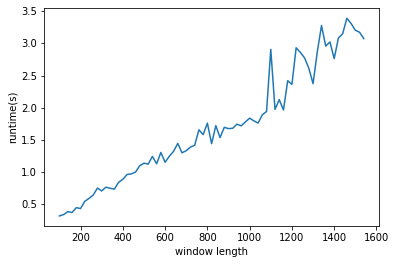

In [37]:
times = []
windows = []
steps = np.array([1, 0, 1, 1]).reshape((2,2))
weights = [1.01,1]
Fquery = extractChromaFeatures('Recordings/30.mp3')
Fref = thirty
for window in range(100, Fquery.shape[1], 20):
    timeStart = time.perf_counter()
    optcost, path, C = subsequenceDTW(Fquery, Fref, steps, weights, window)
    timeEnd = time.perf_counter()
    elapsed_time = timeEnd-timeStart
    windows.append(window)
    times.append(elapsed_time)
plt.plot(windows,times)
plt.xlabel('window length')
plt.ylabel('runtime(s)')

# Trying with different number of steps:


Text(0, 0.5, 'runtime(s)')

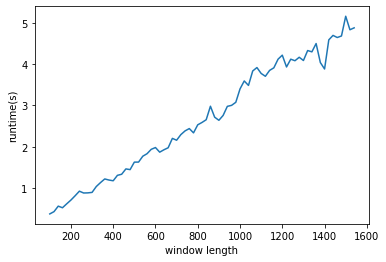

In [38]:
times = []
windows = []
steps = np.array([1, 0, 1, 1,1,2,2,2]).reshape((4,2))
weights = [1.01,1,1,1]
Fquery = extractChromaFeatures('Recordings/30.mp3')
Fref = thirty
for window in range(100, Fquery.shape[1], 20):
    timeStart = time.perf_counter()
    optcost, path, C = subsequenceDTW(Fquery, Fref, steps, weights, window)
    timeEnd = time.perf_counter()
    elapsed_time = timeEnd-timeStart
    windows.append(window)
    times.append(elapsed_time)
plt.plot(windows,times)
plt.xlabel('window length')
plt.ylabel('runtime(s)')

# Variance of the Runtimes:


In [36]:
times = []
steps = np.array([1, 0, 1, 1]).reshape((2,2))
weights = [1.01,1]
chroma_start = time.perf_counter()
Fquery = extractChromaFeatures('Recordings/9.mp3')
chroma_end = time.perf_counter()
chroma_time = chroma_end - chroma_start
Fref = nine
window = Fquery.shape[1]
for i in range(0, 400, 1):
    timeStart = time.perf_counter()
    optcost, path, C = subsequenceDTW(Fquery, Fref, steps, weights, window)
    timeEnd = time.perf_counter()
    elapsed_time = timeEnd-timeStart
    times.append(elapsed_time)
mean, std = norm.fit(times)

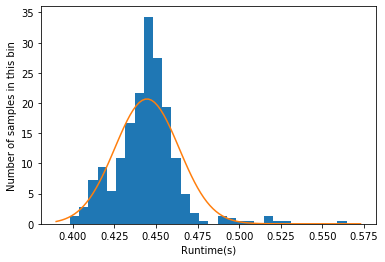

Standard deviation of runtimes is:  0.019294297411806004  seconds


In [37]:
plt.hist(times, bins=30, normed=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.xlabel('Runtime(s)')
plt.ylabel('Number of samples in this bin')
plt.plot(x, y)
plt.show()
print('Standard deviation of runtimes is: ', std, ' seconds')

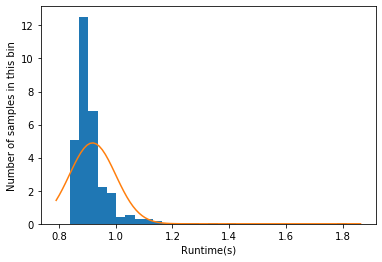

NameError: name 'std' is not defined

In [52]:
chroma_time = []
for i in range(400):
    chroma_start = time.perf_counter()
    Fquery = extractChromaFeatures('Recordings/9.mp3')
    chroma_end = time.perf_counter()
    chroma_time.append(chroma_end - chroma_start)
    
mean_chroma, std_chroma = norm.fit(chroma_time)
plt.hist(chroma_time, bins=30, normed=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean_chroma, std_chroma)
plt.xlabel('Runtime(s)')
plt.ylabel('Number of samples in this bin')
plt.plot(x, y)
plt.show()
print('Standard deviation of runtimes is: ', std, ' seconds')

# Takeaways:
- Increasing the number of steps slightly increases runtime
- Increasing widow size noticably increases runtime
- Runtime is pretty consistent(standard dev of 0.05 seconds for a window of 369 frames)
- Changing weights did not effect runtime


# Possible approach
- calculate the number of frames per second(or find a timestep ~1 second that would be an even number of frames)
- every timestep, run dtw on the last N frames of audio. This window would be picked to make runtime possible, but also make dtw guesses accurate(maybe around 350 frames is a good medium?). 
- This strategy fails when a song has a repeat. To address this, we could also do something where its guess is based on the previous estimates maybe? Runtime gets tricky. We could also potentially eliminate parts of the score based on how long the audio has been going


In [ ]:
#Find the number of windows per 
hop = 1024
sr = 22050
timePerFrame = 1/sr * hop
print(1/timePerFrame) #maybe pick timestep to be 22 frames

In [ ]:
time_loop = []
Fquery_window = []
step = 20
winsize = 10/timePerFrame
Fquery_full = extractChromaFeatures('Recordings/9.mp3')

for i in range(len(Fquery_full[0])//step):
    newFrames = Fquery_full[i*step:step*(i+1)]  #packet of new frames
    time_start = time.perf_counter()            #we should time this
    time.sleep(chroma_time[i]*winsize/len(Fquery_full[0]))# amount of time taken to process Fquery (is this needed?) or can we do it in parallel?
    Fquery_window.append(newFrames)
    
    ## DTW
    
    optcost, path, C = subsequenceDTW(Fquery, Fref, steps, weights, window)
    
    # need to delete the stuff at the beginning to preserve window length
    if len(Fquery_window) > winsize-1:
        Fquery_window = np.delete(Fquery_window,range(20))
    time_loop.append(time.perf_counter()-time_start)

In [ ]:
mean_loop, std_loop = norm.fit(time_loop)
plt.hist(time_loop, bins=30, normed=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean_loop, std_loop)
plt.xlabel('Runtime(s)')
plt.ylabel('Number of samples in this bin')
plt.plot(x, y)
plt.show()
print('Standard deviation of runtimes is: ', std_loop, ' seconds')

In [ ]:
print(Fref.shape[1])
Dlast = np.zeros((window-framesPerStep, Fref.shape[1]))
print(Dlast.shape)
print(e.shape)
print(D.shape)

In [27]:
optcost, path, C = subsequenceDTW(Fquery, Fref, steps, weights, window = 693)

TypeError: subsequenceDTW() got an unexpected keyword argument 'window'

# Simulating Realtime

data (1025, 22)


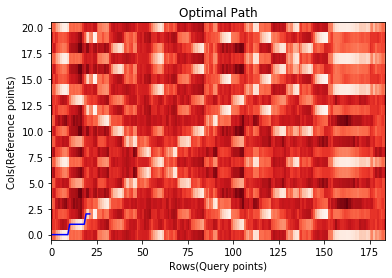

last point of the dtw 2
[[0.023219954648526078], [0.4876190476190476], [0.905578231292517]]


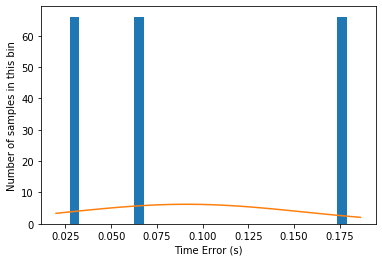

Mean of accuracy is:  0.0911942554799698  seconds
Standard deviation of accuracy is:  0.06404496873564164  seconds
data (1025, 22)
(12, 22) (44, 21)
x 44


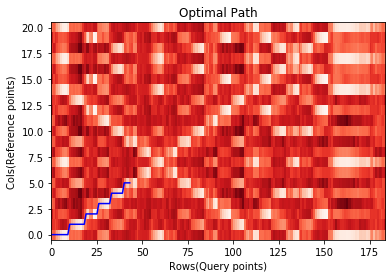

last point of the dtw 5
[[0.023219954648526078], [0.4876190476190476], [0.905578231292517], [1.2306575963718822], [1.5557369614512473], [1.8808163265306124]]


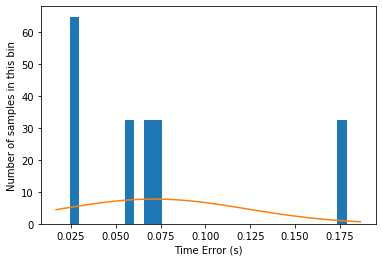

Mean of accuracy is:  0.07122864701436125  seconds
Standard deviation of accuracy is:  0.05158020175602743  seconds
data (1025, 22)
(12, 22) (66, 21)
x 66


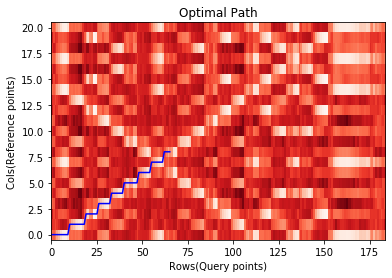

last point of the dtw 8
[[0.023219954648526078], [0.4876190476190476], [0.905578231292517], [1.2306575963718822], [1.5557369614512473], [1.8808163265306124], [2.2523356009070294], [2.5774149659863945], [2.9024943310657596]]


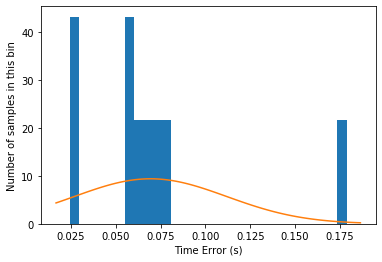

Mean of accuracy is:  0.06934744268077597  seconds
Standard deviation of accuracy is:  0.042519700726315814  seconds
data (1025, 22)
(12, 22) (88, 21)
x 88


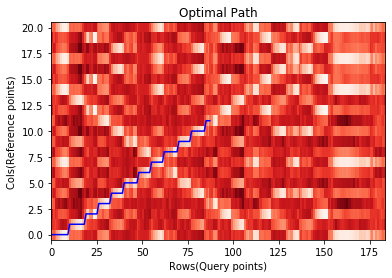

last point of the dtw 11
[[0.023219954648526078], [0.4876190476190476], [0.905578231292517], [1.2306575963718822], [1.5557369614512473], [1.8808163265306124], [2.2523356009070294], [2.5774149659863945], [2.9024943310657596], [3.274013605442177], [3.599092970521542], [3.9706122448979593]]


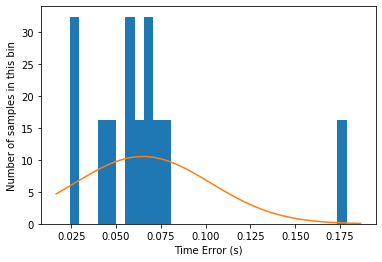

Mean of accuracy is:  0.0649506802721088  seconds
Standard deviation of accuracy is:  0.037934628140974244  seconds
data (1025, 22)
(12, 22) (110, 21)
x 110


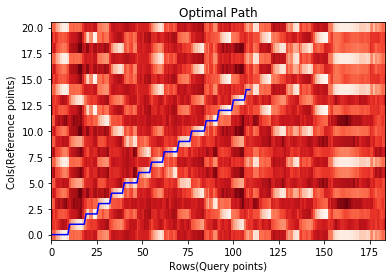

last point of the dtw 14
[[0.023219954648526078], [0.4876190476190476], [0.905578231292517], [1.2306575963718822], [1.5557369614512473], [1.8808163265306124], [2.2523356009070294], [2.5774149659863945], [2.9024943310657596], [3.274013605442177], [3.599092970521542], [3.9706122448979593], [4.295691609977324], [4.667210884353741], [4.992290249433107]]


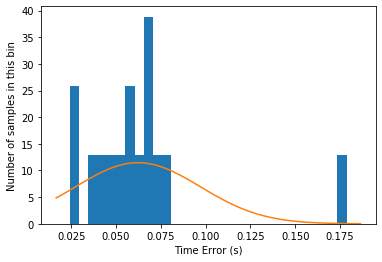

Mean of accuracy is:  0.06228102796674225  seconds
Standard deviation of accuracy is:  0.0347974741335895  seconds
data (1025, 22)
(12, 22) (132, 21)
x 132


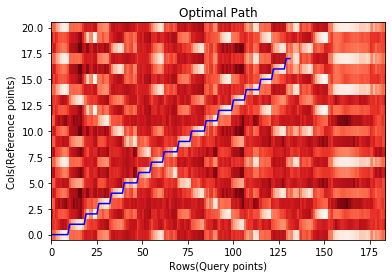

last point of the dtw 17
[[0.023219954648526078], [0.4876190476190476], [0.905578231292517], [1.2306575963718822], [1.5557369614512473], [1.8808163265306124], [2.2523356009070294], [2.5774149659863945], [2.9024943310657596], [3.274013605442177], [3.599092970521542], [3.9706122448979593], [4.295691609977324], [4.667210884353741], [4.992290249433107], [5.363809523809524], [5.688888888888889], [6.013968253968254]]


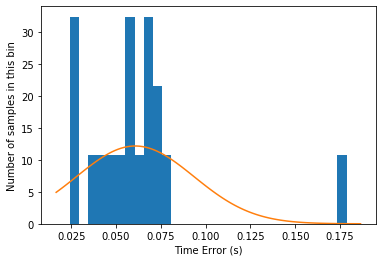

Mean of accuracy is:  0.06075270849080375  seconds
Standard deviation of accuracy is:  0.032794147512816764  seconds
data (1025, 22)
(12, 22) (154, 21)
x 154


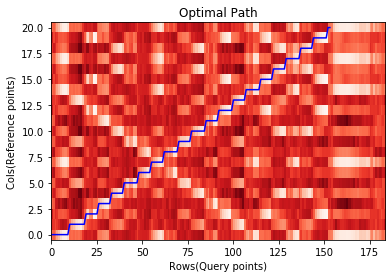

last point of the dtw 20
[[0.023219954648526078], [0.4876190476190476], [0.905578231292517], [1.2306575963718822], [1.5557369614512473], [1.8808163265306124], [2.2523356009070294], [2.5774149659863945], [2.9024943310657596], [3.274013605442177], [3.599092970521542], [3.9706122448979593], [4.295691609977324], [4.667210884353741], [4.992290249433107], [5.363809523809524], [5.688888888888889], [6.013968253968254], [6.3854875283446715], [6.710566893424036], [7.082086167800454]]


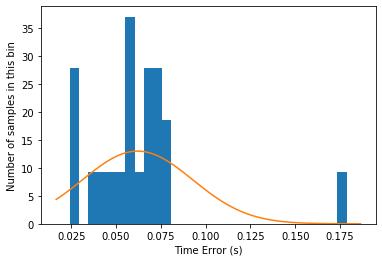

Mean of accuracy is:  0.06206705539358599  seconds
Standard deviation of accuracy is:  0.03071690160600297  seconds
data (1025, 22)
(12, 22) (176, 21)
x 176


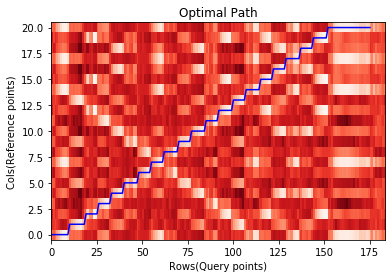

last point of the dtw 20
[[0.023219954648526078], [0.4876190476190476], [0.905578231292517], [1.2306575963718822], [1.5557369614512473], [1.8808163265306124], [2.2523356009070294], [2.5774149659863945], [2.9024943310657596], [3.274013605442177], [3.599092970521542], [3.9706122448979593], [4.295691609977324], [4.667210884353741], [4.992290249433107], [5.363809523809524], [5.688888888888889], [6.013968253968254], [6.3854875283446715], [6.710566893424036], [7.082086167800454]]


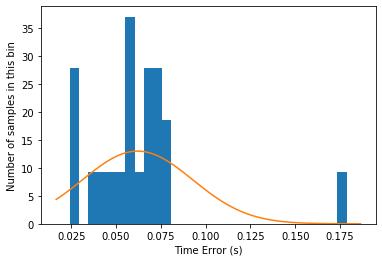

Mean of accuracy is:  0.06206705539358599  seconds
Standard deviation of accuracy is:  0.03071690160600297  seconds
data (1025, 8)
(12, 8) (184, 21)
x 184


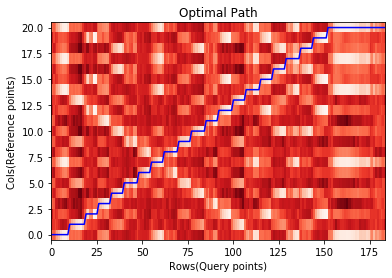

last point of the dtw 20
[[0.023219954648526078], [0.4876190476190476], [0.905578231292517], [1.2306575963718822], [1.5557369614512473], [1.8808163265306124], [2.2523356009070294], [2.5774149659863945], [2.9024943310657596], [3.274013605442177], [3.599092970521542], [3.9706122448979593], [4.295691609977324], [4.667210884353741], [4.992290249433107], [5.363809523809524], [5.688888888888889], [6.013968253968254], [6.3854875283446715], [6.710566893424036], [7.082086167800454]]


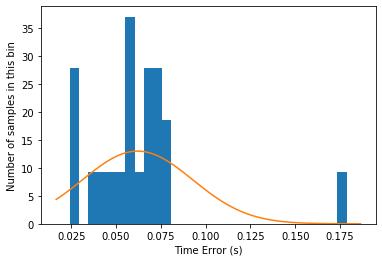

Mean of accuracy is:  0.06206705539358599  seconds
Standard deviation of accuracy is:  0.03071690160600297  seconds


In [96]:
#Find the number of windows per loop
#Set stft and general parameters
#SAVE MOST OF PREVIOUS C AND D, ONLY CALC FROM THE NEW CHROMA!! 
hop = 1024
sr = 22050
winsize = 2048
window = 350
#calculate time per frame 
timePerFrame = 1/sr * hop
#Set the update rate by the amount of frames of the STFT between updates. 22 frames is about 1 second
framesPerStep = 22
#use this to calculate the time step of the loop
timeStep = 3*timePerFrame

#precalculate the number of frames of the STFT, load the audio as data that can be read
query = 'Recordings/11.mp3'
Y, sr  = lb.core.load(query, sr = sr)
frames = math.ceil(Y.shape[0]/hop + 1) #Find the number of frames. 1024 is the hopsize
Fref = eleven
t_ref = elevent # onset time of each note
#set DTW parameters
steps = np.array([1, 0, 1, 1]).reshape((2,2))
weights = [1.01,1]
e = computeCostMatrix_cosdist(Fquery,Fref)

#set up looping parameters
i=0
Cprev = None
Dprev = None
Bprev = None
Fquery = np.empty((12,0), int)
recording = True
startTime=time.time()           #create a clock to iterate the loop every timeStep
#w is only needed if plotting
w=1
while recording:
    #Find the STFT of new data, calculate new chroma features, and add them to the overall query
    try:
        newData = magSTFTFromFile(Y[i*hop:(i+framesPerStep-1)*hop])
        if len(Y[i*hop:(i+framesPerStep-1)*hop])%hop != 0:
            newData = newData[:, :-1]
    except:
        break
    print('data',newData.shape)
    newChroma = extractChromaFromS(newData)  #packet of new frames
    Fquery = np.hstack((Fquery, newChroma))
    #if statement is optional. It prevents it from updating unless a number of frames equal to window
    #are already in Fquery
        #take the DTW of the new path segment
    if Cprev is not None:
        Cnew = np.vstack((Cprev, computeCostMatrix_cosdist(newChroma,Fref)))
        print(newChroma.shape, Cnew.shape)
        optcost, path, D, B = subsequenceDTWContinue(Cnew, Dprev, Bprev, steps, weights, newData.shape[1])
        Cprev = Cnew
        Dprev = D
        Bprev = B
        
    else:
        Cnew = computeCostMatrix_cosdist(newChroma,Fref)
        optcost, path, D, B = subsequenceDTW(Cnew, steps, weights)
        Cprev = Cnew
        Dprev = D
        Bprev = B
                             
    path_x = [point[0] for point in path]
    path_y = [point[1] for point in path]
    ######Comment from here::
    fig = plt.figure(1)
    plot1 = plt.imshow(e.T, origin='lower', cmap='Reds', interpolation='nearest', aspect = 'auto')
    plot2 = plt.plot(path_x, path_y, 'B')
    xlim = ax.set_xlim((-0.5, Cprev.shape[0]-0.5))
    ylim = ax.set_ylim((-0.5, Cprev.shape[1]-0.5))
    plt.xlabel("Rows(Query points)")
    plt.ylabel("Cols(Reference points)")
    plt.title("Optimal Path")
    plt.show()
    w=w+1
    ######## To here to have just functionality and no plotting
    i = i+framesPerStep
    lastPoint = path[0][1]
    print('last point of the dtw', lastPoint)
    if i >= frames:
        recording = False
    time.sleep(timeStep - ((time.time() - startTime) % timeStep))
    
    dtwError = accuracy(path_x,path_y,t_ref,hop/sr)
    t_mean, t_std = norm.fit(dtwError)
    
    # plot accuracy data

    plt.hist(dtwError, bins=30, normed=True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, t_mean, t_std)
    plt.xlabel('Time Error (s)')
    plt.ylabel('Number of samples in this bin')
    plt.plot(x, y)
    plt.show()

    print('Mean of accuracy is: ',t_mean,' seconds')
    print('Standard deviation of accuracy is: ', t_std, ' seconds')

[[0.023219954648526078], [0.4876190476190476], [0.905578231292517], [1.2306575963718822], [1.5557369614512473], [1.8808163265306124], [2.2523356009070294], [2.5774149659863945], [2.9024943310657596], [3.274013605442177], [3.599092970521542], [3.9706122448979593], [4.295691609977324], [4.667210884353741], [4.992290249433107], [5.363809523809524], [5.688888888888889], [6.013968253968254], [6.3854875283446715], [6.710566893424036], [7.082086167800454]]


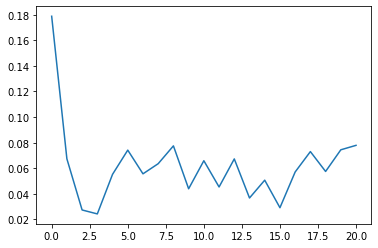

In [95]:
def accuracy(path_query,path_reference,times,hop_sec):
    '''
    path_query - the path indices of the query (path_x)
    path_reference - path indices of the reference (path_y)
    times - onset times for the reference (elevent)
    hop_sec - hop size in seconds
    
    Returns the time error between the query and reference for each note.
    '''
    query = path_query[::-1]
    ref = path_reference[::-1]
    step = -1 # the reference index that the input is on
    dtwtime = []
    for i in range(len(path_reference)):
        if ref[i] > step:
            dtwtime.append([(i+0.5)*hop_sec])
            step = ref[i]
    print(dtwtime)
    times = np.asarray(times).reshape(len(times),1)
    return times[:len(dtwtime)]-np.asarray(dtwtime)

### STFT Functions

Functions for modifying STFTs
- magSTFT calculates the normal and magnitude STFT
- logCompression applies elementwise logarithmic compression 
- harmonicSummation sums the harmonics of a log frequency STFT


In [4]:
def magSTFT(mp3file, sr = 22050, winsize = 2048, hop = 1024, gamma = 10000):
    '''
    Calculate the STFT for an MP3
    
    Arguments:
    mp3file -- target mp3 file
    
    Returns:
    S = STFT
    Smag -- magnitude STFT
    '''
    Y, sr  = lb.core.load(mp3file, sr = sr)
    f, t, S = ss.stft(Y, fs = sr, nperseg = winsize, noverlap = winsize - hop)
    Smag = np.abs(S)
    return S, Smag

In [5]:
def magSTFTFromFile(Y, sr = 22050, winsize = 2048, hop = 1024, gamma = 10000):
    '''
    Calculate the STFT for an MP3
    
    Arguments:
    mp3file -- target mp3 file
    
    Returns:
    S = STFT
    Smag -- magnitude STFT
    '''
    f, t, S = ss.stft(Y, fs = sr, nperseg = winsize, noverlap = winsize - hop)
    Smag = np.abs(S)
    return Smag

In [6]:
def harmonicSummation(S_lf, bins=12, numHarmonics=5):
    '''
    Sum harmonics in a log frequency spectrogram
    
    Arguments:
    S_lf -- log frequency STFT
    bins -- bins per octave
    numHarmonics -- number of harmonics to sum
    
    Returns:
    harmonicsSummed -- logSTFT with harmonics summed
    '''
    filterBins = np.round(bins * np.log2(np.arange(numHarmonics)+1)).astype(int)
    height = np.amax(filterBins)
    filters = np.zeros((height+1, 1))
    filters[filterBins] = 1
    filters = np.flipud(filters)
    harmonicsSummed = ss.convolve2d(S_lf, filters)
    harmonicsSummed = harmonicsSummed[harmonicsSummed.shape[0] - S_lf.shape[0]:, :]
    return harmonicsSummed

In [7]:
def logCompression(F, gamma = 10000):
    '''
    Apply element-wise logarithmic compression.
    
    Arguments:
    F -- input matrix
    gamma -- scalar that controls the level of compression as ln(1 + gamma * c)
    
    Returns:
    Fc -- matrix of logarithmically compressed values.  Fc is of the same size as F.
    '''
    Fc = np.zeros_like(F)
    for x in range(0, len(F)):
        for y in range(0, len(F[0])):
            Fc[x][y] = np.log(1+gamma*F[x][y])
    return Fc

In [8]:
def plotLinearSpec(S, hop=1024, sr=22050, plotname='test', log = True):
    plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
    S = abs(S)
    title = 'STFT of:  '
    if log:
        S = np.log(S)
        title = 'log STFT of:  '
    plt.imshow(S, origin='lower', cmap = 'jet', aspect = 'auto')
    plt.title(title + plotname)
    plt.xlabel('frame number')
    plt.ylabel('Chroma Feature')
    plt.colorbar()


### Extracting Chroma Features from input MP3

Chroma feature process
- determine the log frequency conversion matrix by calling getLogFreqConversionMatrix()
- determine the chroma conversion matrix by calling getChromaConversionMatrix()
- sum harmonics on the log frequency matrix
- compute chroma features by applying the chroma conversion matrix
- apply element-wise logarithmic compression by calling logCompression()
- L2 normalize each column by calling normL2()

In [9]:
def getLogFreqConversionMatrix(N, fs):
    '''
    Determine the log frequency conversion matrix that can be used to pre-multiply a one-sided spectrogram
    to get a log frequency spectrogram.
    
    Arguments:
    N -- analysis window size
    fs -- sampling rate
    
    Returns:
    B -- a binary matrix of shape (128, (N/2)+1).  The log frequency spectrogram can be computed
         by computing the matrix product of B and the spectrogram matrix.
    '''
    numBins = int(N/2) + 1
    pitchMax = 128
    B = np.zeros((pitchMax, numBins))
    p = np.arange(pitchMax)
    pitchFrequencies = []
    for pitch in range(0, len(p)):
        pitchFrequencies.append([440*N/fs * 2**(((pitch-0.5) - 69)/12), 440*N/fs * 2**(((pitch+0.5) - 69)/12)])
        initIndex = int(pitchFrequencies[pitch][0])
        while initIndex<pitchFrequencies[pitch][1]:
            try:
                if pitchFrequencies[pitch][0]<initIndex and initIndex<pitchFrequencies[pitch][1]:
                    B[pitch][initIndex] = 1
            except:
                pass
            initIndex +=1
    return B

In [10]:
def getChromaMatrix(logF):
    '''
    Determine the chroma feature matrix that can be used to pre-multiply a one-sided spectrogram
    to calculate chroma features.
    
    Arguments:
    logF -- log Frequency STFT(can have harmonics summed)
    
    Returns:
    F -- a chroma feature matrix with the same number of columns as the STFT, but only 12 rows
    '''
    F = np.zeros([12, logF.shape[1]])
    for c in range(0, logF.shape[1]):
        for x in range(0, 12):
            num = 0
            for y in range(x, logF.shape[0], 12):
                num += logF[y][c]
            F[x][c] += num
    return F

In [11]:
def normL2(F):
    '''
    Normalize each column of a matrix to have unit L2 norm.
    
    Arguments:
    F -- input feature matrix where each column corresponds to a single feature vector
    
    Returns:
    Fnorm -- normalized feature matrix of the same shape as F, where each column has been
             been normalized to be unit L2 norm
    '''
    row, col = F.shape
    for x in range(0, col):
        norm = np.linalg.norm(F[:,x])
        F[:,x] = F[:,x]/ (norm + 1e-9)
    Fnorm = F
    return Fnorm

(12, 569)


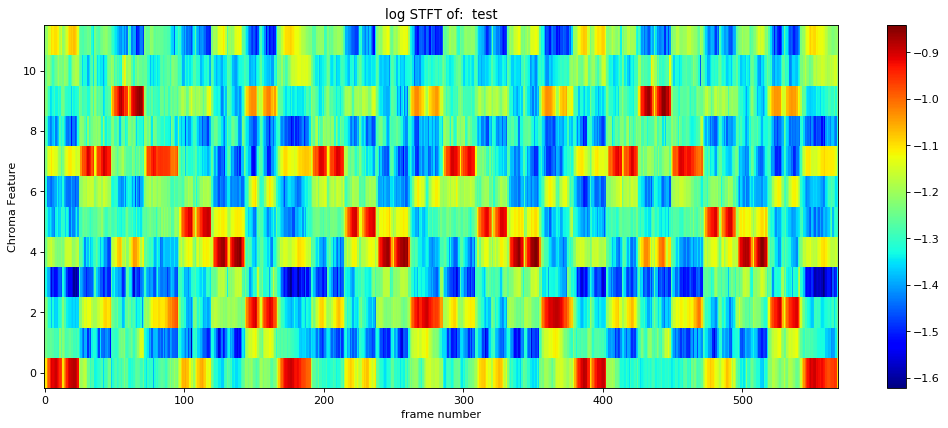

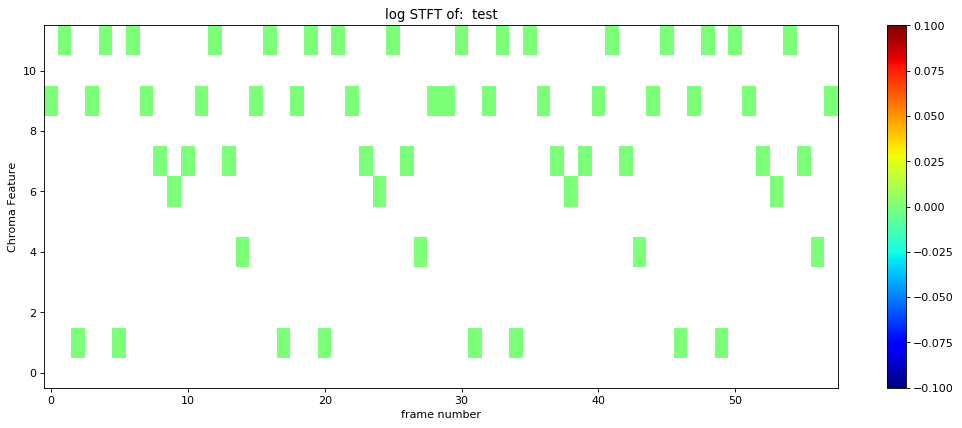

In [14]:
def extractChromaFeatures(mp3file, sr = 22050, winsize = 2048, hop = 1024, gamma = 100000):
    '''
    Compute chroma feature matrix on a specified audio file.
    
    Arguments:
    Smag --  magnitude STFT
    sr -- desired sampling rate in Hz
    winsize -- analysis window size in samples
    hop -- hop size in samples
    gamma -- coefficient used in log compression
    
    Returns:
    F -- chroma feature matrix of size (12, M), where M is the number of audio frames.  The
         features have logarithmic compression and each column is L2 normalized.
    '''
    S,Smag = magSTFT(mp3file)
    height, width = Smag.shape
    B = getLogFreqConversionMatrix(winsize, sr)
    logF = np.dot(B,Smag)
    #logFsummedHarmonics = harmonicSummation(logF)
    f = getChromaMatrix(logF) #Change logFsummedHarmonics to logF to test without harmonic summation
    f1 = logCompression(f, gamma)
    F = normL2(f1)
    return F
F = extractChromaFeatures('Recordings/12.mp3')
print(F.shape)
plotLinearSpec(F)
Fref = four
plotLinearSpec(Fref)

In [12]:
def extractChromaFromS(Smag, sr = 22050, winsize = 2048, hop = 1024, gamma = 100000):
    '''
    Compute chroma feature matrix on a specified audio file.
    
    Arguments:
    Smag --  magnitude STFT
    sr -- desired sampling rate in Hz
    winsize -- analysis window size in samples
    hop -- hop size in samples
    gamma -- coefficient used in log compression
    
    Returns:
    F -- chroma feature matrix of size (12, M), where M is the number of audio frames.  The
         features have logarithmic compression and each column is L2 normalized.
    '''
    height, width = Smag.shape
    B = getLogFreqConversionMatrix(winsize, sr)
    logF = np.dot(B,Smag)
    #logFsummedHarmonics = harmonicSummation(logF)
    f = getChromaMatrix(logF) #Change logFsummedHarmonics to logF to test without harmonic summation
    f1 = logCompression(f, gamma)
    F = normL2(f1)
    return F

# Score Chroma Features

In [29]:
C= [1,0,0,0,0,0,0,0,0,0,0,0]
Cs = [0,1,0,0,0,0,0,0,0,0,0,0]
D= [0,0,1,0,0,0,0,0,0,0,0,0]
Ds =[0,0,0,1,0,0,0,0,0,0,0,0] 
E = [0,0,0,0,1,0,0,0,0,0,0,0] 
F= [0,0,0,0,0,1,0,0,0,0,0,0] 
Fs = [0,0,0,0,0,0,1,0,0,0,0,0] 
G= [0,0,0,0,0,0,0,1,0,0,0,0] 
Gs= [0,0,0,0,0,0,0,0,1,0,0,0]
A= [0,0,0,0,0,0,0,0,0,1,0,0]
As= [0,0,0,0,0,0,0,0,0,0,1,0]
B= [0,0,0,0,0,0,0,0,0,0,0,1]



one = np.transpose(np.vstack([A,B,Cs,D,E,Fs,Gs,A,B,Cs,D,E,Fs,Gs,A,B,Cs,D,E,Fs,Gs,A,Gs,Fs,E,D,Cs,B,A,Gs,Fs,E,D,Cs,B,A,Gs,Fs,E,D,Cs,B,A,B,Cs,D,E,Fs,Gs,A,B,Cs,D,E,Fs,Gs,A,B,Cs,D,E,Fs,Gs,A,Gs,Fs,E,D,Cs,B,A,Gs,Fs,E,D,Cs,B,A,Gs,Fs,E,D,Cs,B,A]))

two = np.transpose(np.vstack([C,Cs,D,Ds,E,F,Fs,G,Gs,A,As,B,C,Cs,D,Ds,E,F,Fs,G,Gs,A,As,B,C,B,As,A,Gs,G,Fs,F,E,Ds,D,Cs,C,B,As,A,Gs,G,Fs,F,E,Ds,D,Cs,C,
       Cs,D,Ds,E,F,Fs,G,Gs,A,As,B,C,Cs,D,Ds,E,F,Fs,G,Gs,A,As,B,C,
       B,As,A,Gs,G,Fs,F,E,Ds,D,Cs,C,B,As,A,Gs,G,Fs,F,E,Ds,D,Cs,C]))
three = np.transpose(np.vstack([E,D,C,D,E,E,E,D,D,D,E,G,G,E,D,C,D,E,E,E,D,D,D,E,D,C]))
#threeT = [3,1,2,2,2,2,4,2,2,4,2,2,4,3,1,2,2,2,2,4,2,1,1,2,2,6]
four = np.transpose(np.vstack([A,B,Cs,A,B,Cs,B,A,G,Fs,G,A,B,G,E,A,B,Cs,A,B,Cs,B,A,G,
       Fs,B,G,E,A,A,B,Cs,A,B,Cs,B,A,G,Fs,G,A,B,G,E,A,B,Cs,A,B,Cs,B,A,G,
       Fs,B,G,E,A]))
five = np.transpose(np.vstack([Gs,As,C,Cs,Ds,F,G,Gs,As,C,Cs,Ds,F,G,Gs,
        G,F,Ds,Cs,C,As,Gs,G,F,Ds,Cs,C,As,Gs,
        As,C,Cs,Ds,F,G,Gs,As,C,Cs,Ds,F,G,Gs,
        G,F,Ds,Cs,C,As,Gs,G,F,Ds,Cs,C,As,Gs]))
six = np.transpose(np.vstack([Cs, D, F, As, As, Cs, D, F, Gs, Gs, F, G, Cs, D, F, F, Gs,
    C, C, D, F, F, F, Ds, D, C, D, Ds, D, C, As, C, D, C, As, A, As,
    Cs, B, A, G, A, C, As, Gs, G, F]))

seven = np.transpose(np.vstack([Gs, B, Gs, B, Gs, Gs, B, Gs, B, Gs, Gs, B, Gs, B, Gs, 
    Cs, Gs, B, Gs, Cs, Gs, Cs, B, Gs, Cs, Cs, Cs, Fs, As, Fs, Cs, As, 
    Gs, G, Fs, D, Cs, D, Cs, Cs, E, Cs, E, Fs, Cs, E, Cs, Cs, E, Cs, A, Gs, E, Cs]))

eight = np.transpose(np.vstack([B, As, B, As, Ds, Fs, F, As, Ds, C, B, As, B, As, Ds, Fs, F, As, C, 
    Ds, B, As, B, As, Ds, Fs, F, As, Ds, C, B, As, B, As, Ds, Fs, F, As, C, Ds,
    As, C, Cs, G, F, Ds, F, G, D, C, Gs, A, As, Gs, G, Ds]))

nine = np.transpose(np.vstack([G,E,E,F,D,D,C,D,E,F,G,G,G,G,E,E,E,F,D,D,D,C,E,G,G,E,E,
    E,D,D,D,D,D,E,F,E,E,E,E,E,F,G,G,E,E,E,F,D,D,D,C,E,G,G,E,E,E]))
ten = np.transpose(np.vstack([G,A,G,F,E,F,G,D,E,F,E,F,G,G,A,G,F,E,F,G,D,G,E,C]))
eleven = np.transpose(np.vstack([C,D,E,F,G,A,B,C,B,A,G,F,E,D,C,E,G,C,G,E,C]))
elevent = [0.202, 0.555, 0.933, 1.255, 1.611, 1.955, 2.308, 2.641, 2.980, 3.318, 3.665, 4.016, 4.363, 4.704, 5.043, 5.393, 5.746, 6.087, 6.443, 6.785, 7.160]
twelve = np.transpose(np.vstack([C,C,G,G,A,A,G,F,F,E,E,D,D,C,G,G,F,F,E,E,D,G,G,F,F,E,E,D,C,C,G,G,A,A,G,F,F,E,E,D,D,C]))
thirteen = np.transpose(np.vstack([A, Fs, D, Fs, G, A, As, C, D, Ds, Fs, G, D, A, Fs, D, Fs, G, D, Cs,As, A, G, Fs, Fs, D, A, Fs, D, As, A, G, A, As, C, D, Ds, Fs, G, D, A, Fs, D, Fs, G, D, Cs, As, A, G, Fs, Fs, D]))
fourteen = np.transpose(np.vstack([C,C,D,C,F,E,C,C,D,C,G,F,C,C,C,A,F,E,D,As,As,A,F,G,F,C,C,D,C,F,E,C,C,D,C,G,F,C,C,C,A,F,E,D,As,As,A,F,G,F]))
fifteen = np.transpose(np.vstack([Fs, D, G, A, G, Fs, E, Fs, B, Cs, E, D, E, D, Cs, D, B, Cs, B, A, B,
    A, Gs, A, Cs, Cs, B, A, B, A, Gs, A, Cs, B, A, Cs, B, Cs, B, A, Cs, Cs, B, As, Cs,
    B, Cs, B, As, Fs]))
sixteen = np.transpose(np.vstack([A,B,C,D,E,F,G,A,B,C,D,E,F,G,A,G,F,E,D,C,B,A,G,F,E,D,C,B,
    A,B,C,D,E,F,G,A,B,C,D,E,F,G,A,G,F,E,D,C,B,A,G,F,E,D,C,B,A]))
seventeen = np.transpose(np.vstack([E,E,D,C,C,D,D,E,D,C,G,G,F,E,E,D,C,D,E,C,E,E,F,G,G,
    A,A,G,F,E,E,E,F,G,G,A,A,G,E,E,D,C,C,D,D,E,D,C,G,G,F,E,E,D,C,D,E,C]))
eighteen = np.transpose(np.vstack([C,F,E,F,A,C,F,F,E,D,C,F,G,A,As,D,F,G,A,
    C,G,C,F,E,F,A,C,A,A,G,F,E,F,A,D,F,E,Ds,D,E,C]))
nineteen = np.transpose(np.vstack([B,G,Fs,E,D,A,B,G,Fs,E,D,A,B,G,E,D,C,G,A,D,B,B,C,A,B,G,A,Fs,G,E,Fs,G,A,B]))
twenty = np.transpose(np.vstack([C,D,E,F,G,A,B,C,B,A,G,F,E,D,C]))
twentyone = np.transpose(np.vstack([A,Cs,E,A,Cs,E,A,E,Cs,A,E,Cs,A,Cs,E,A,Cs,E,A,E,Cs,A,
    E,Cs,A,Cs,E,A,Cs,E,A,E,Cs,A,E,Cs,A,Cs,E,A,Cs,E,A,E,Cs,A,E,Cs,A]))

twentytwo = np.transpose(np.vstack([E,D,C,G,F,E,E,D,C,G,F,E,G,F,E,D,C,C,A,E,F,Fs,G,C,Ds,E,C,E,D,C,G,F,E,E,D,C,G,F,E,G,F,E,D,C,C,A,E,F,Fs,G,C,Ds,E,C]))

twentythree = np.transpose(np.vstack([D,C,A,C,C,D,C,G,E,C,D,C,A,C,B,B,B,B,A,G,E,D,C,G,F,E,E,D,C,G,F,E,G,F,E,D,C,C,A,E,F,Fs,G,C,Ds,E,C]))

twentyfour = np.transpose(np.vstack([G,Fs,G,Fs,E,G,Fs,G,Fs,G,Fs,E,Gs,B,Gs,F,E,A,G,A,G,E,A,G,Ds,G,D,E,G,A,B,E,D,G,Fs,G,Fs,E,G,Fs,G,Fs,G,Fs,E,Gs,B,Gs,F,E,A,G,A,G,E,A,G,Ds,G,D,E,G,A,As,A,G]))
twentyfive = np.transpose(np.vstack([Ds,C,Ds,C,As,G,As,C,D,Ds,C,Ds,As,Ds,C,E,C,As,G,As,C,D,Ds,As,C,D,G,Fs,G,Fs,E,G,Fs,G,Fs,G,Fs,E,Gs,B,Gs,F,E,A,G,A,G,E,A,G,Ds,G,D,E,G,A,As,A,G]))
twentysix = np.transpose(np.vstack([A,D,E,F,E,F,B,A,G,Fs,G,D,Cs,C,B,A,Gs,A,G,G,A,B,E,E,G,G,G,Gs,Gs,Gs,A,A,B,B,B]))
twentyseven = np.transpose(np.vstack([As,C,D,As,C,D,As,C,D,F,Ds,D,As,C,Cs,Ds,F,G,Ds,F,G,Ds,F,G,As,Gs,G,Ds,F,Fs,F,G,Gs,A,B,E,G,As,B,E,Ds,C,B,A,G,F,G,Gs,As,Ds,G,As,B,E,Ds,C,As,Gs,G]))
twentyeight = np.transpose(np.vstack([G,E,E,D,G,E,E,E,D,G,E,E,D,G,G,E,E,E,D,F,D,D,D,C,E,C,C,C,As,C,G,E,E,D,G,E,E,E,D,G,E,E,D,G,G,E,E,E,D,F,D,D,D,C,E,C,C,C,As,C]))
twentynine = np.transpose(np.vstack([F,Fs,Ds,F,Ds,Cs,Ds,Gs,A,Gs,Fs,Gs,Fs,E,Fs,A,As,A,G,A,G,F,G,A,As,C,C,D,E,F,G,Gs,A,As,As,C,D,E,F,Fs,G,E,E,D,G,E,E,E,D,G,E,E,D,G,G,E,E,E,D,A,F,F,F,D,C,E,E,E,D,D]))
thirty = np.transpose(np.vstack([Ds,F,G,G,F,Ds,F,G,G,F,As,C,Cs,Cs,C,As,C,Cs,As,G,G,G,F,C,G,G,F,B,G,As,As,G,As,G,G,As,As,C,Ds,Ds,Ds,F,G,G,F,Ds,F,G,G,F,As,C,Cs,Cs,C,As,C,Cs,As,G,G,G,F,C,G,G,F,B,G,As,As,G,As,G,G,As,As,C,Ds,Ds]))
thirtyone = np.transpose(np.vstack([Ds,C,Ds,C,Ds,C,Ds,D,As,D,As,D,Ds,C,Ds,C,Ds,C,Ds,As,C,C,C,F,Ds,F,G,G,F,Ds,F,G,G,F,As,C,Cs,Cs,C,As,C,Cs,As,G,G,G,F,C,G,G,F,B,G,As,As,G,As,G,G,As,As,As,C,Ds,Ds]))
thirtytwo = np.transpose(np.vstack([G,G,As,G,F,G,G,G,As,G,F,G,G,G,As,G,F,G,G,G,As,G,F,G,D,G,A,As,As,C,As,G,G,A,As,As,F,Gs,Gs,Gs,As,Gs,Fs,F,F,F,Gs,Gs,Cs,Fs,Gs,A,A,A,B,A,Fs,Fs,A,A,A,A,A,A,B,A,Fs,Fs,A,A,D,D,C,D,C,As,D,C,C,As,As,C,C,G,G,G,F,Ds,F,G,As,G,Ds,F,Fs]))
thirtythree = np.transpose(np.vstack([A,D,C,D,C,D,E,F,G,A,As,C,D,G,F,G,F,A,As,A,D,C,D,C,D,E,F,G,A,As,C,D,G,F,G,F,A,C,D,D,D,C,As,F,G,Gs,Gs,Gs,Gs,Gs,Fs,Cs,Ds,E,E,E,E,E,D,Fs,A,Cs,Cs,As,A,D,C,D,C,D,E,F,G,A,As,C,D,E,D,A,G,F]))
thirtyfour = np.transpose(np.vstack([A,Gs,As,C,C,Ds,D,As,G,C,Ds,C,As,G,F,As,F,G,F,Gs,As,C,C,Ds,F,D,C,C,Ds,C,As,G,F,As,F,G,C,G,Ds,F,G,Gs,As,C,Gs,F,G,Gs,As,C,D,E,D,As,A,A,A,Gs,As,C,C,Ds,D,As,G,C,Ds,C,As,G,F,As,F,G,F,Gs,As,C,C,Ds,F,D,C,C,Ds,C,As,G,F,As,F,G]))
thirtyfive = np.transpose(np.vstack([D,G,A,A,B,D,G,A,As,C,F,G,G,A,C,F,G,Gs,D,Ds,F,G,G,G,G,G,G,A,G,A,As,A,G,A,B,A,B,C,D,D,D,D,D,D,G,A,A,B,D,G,A,As,C,F,G,G,A,C,F,G,Gs,D,Ds,F,G,G,G,G,G,G,A,G,A,B,A,B,C,D,D,D,D,D,D,G,A,G]))
thirtysix = np.transpose(np.vstack([A,As,A,As,A,As,A,As,A,Gs,A,C,B,As,A,A,G,G,A,G,A,G,A,G,A,G,Fs,G,As,A,Gs,G,G,F,F,G,F,G,F,G,F,G,A,F,D,E,D,E,F,F,F,G,F,G,E,F,E,F,E,Ds,E,G,Fs,F,E,E,D]))
thirtyseven = np.transpose(np.vstack([E,F,G,B,A,G,E,D,E,G,E,D,E,G,E,D,E,C,E,G,A,B,C,C,C,D,B,A,A,G,E,Fs,G,G,G,A,Fs,G,E,F,G,B,A,G,E,D,E,G,E,D,E,G,E,D,E,C,E,G,A,B,C,C,C,D,B,As,As,A,G,F,E,E,D,C,B,C]))
thirtyeight = np.transpose(np.vstack([Ds,F,G,As,C,As,C,As,Cs,C,As,Ds,F,G,As,C,As,Cs,C,As,Ds,F,F,D,C,A,F,D,C,F,C,D,F,Cs,Ds,Cs,Fs,F,D,C,A,F,D,C,F,A,A,F,C,D,F,F,D,C,A,F,D,C,F,C,D,F,Cs,Ds,Cs,Fs,F,D,C,A,F,D,C,F,A,A,F,C,D,F,C,G,Cs,C,C,D,F,Cs,Gs,Cs,D,Ds,E,F,D,C,A,F,D,C,F,C,D,F,Cs,Ds,Cs,Fs,F,D,C,A,F,D,C,F,A,A,F,C,D,F]))
thirtynine = np.transpose(np.vstack([C,Ds,G,As,A,Ds,F,G,G,G,B,D,F,D,Ds,C,Ds,F,G,Ds,C,Ds,Ds,As,G,F,D,Ds,F,G,Gs,As,As,B,Gs,D,As,C,G,C,D,Ds,D,C,As,C,D,D,G,A,As,A,G,Gs]))
forty = np.transpose(np.vstack([As,G,F,D,Ds,F,G,Gs,As,As,B,Gs,D,As,C,G,C,D,Ds,F,As,C,Cs,C,F,C,Fs,D,G,Ds,C,D,Ds,D,C,As,C,D,Cs,C,Ds,F,G,C,Ds,F,Fs,B,As,F,G,Gs,Gs,As,Gs,G,F,G,G,C,D,Ds,Ds,F,Ds,D,C,D,G,As,D,C,As,G,F,D,Ds,D,G,Gs,As,As,B,Gs,D,B,C,G,C,D,Ds,F,As,C,Cs,C,Ds,F,G,C,Ds,F,Fs,D,Ds]))
fortyone = np.transpose(np.vstack([C,B,B,A,B,C,B,A,B,B,As,E,A,E,F,G,D,E,F,F,E,F,E,F,E,E,E,E,F,E,G,F,E,D,E,D,F,E,C,C,D,E,C,D,E,A,B,G,A,B,C,B,B,A,B,C,B,A,B,B,As,E,A,E,F,G,D,E,F,F,E,F,E,F,E,G,F,E,B,Gs,A,D,As,C,A,B,A,B,C]))


# Subsequence DTW

DTW overall process
- compute the cost matrix based on cosine distance
- use dynamic programming to find our cumulative cost matrix and our backtrace matrix
- construct the optima

In [15]:
def computeCostMatrix_cosdist(Fquery,Fref, window=None):
    '''
    Computes the cosine distance cost matrix.
    
    Arguments:
    Fquery -- the query chroma feature matrix of dimension (12, # query frames), this feature
              matrix is assumed to be L2 normalized
    Fref -- the reference feature matrix, of dimension (12, # reference frames), this feature
            matrix is assumed to be L2 normalized
    
    Returns:
    C -- cost matrix whose (i,j)th element specifies the cosine distance between the i-th query frame
         and the j-th reference frame
    '''
    if window is not None:
        Fquery = Fquery[:,-window:]
    product = np.dot(np.transpose(Fquery), Fref)
    ones = np.ones_like(product)
    C = 1- product
    return C

In [18]:
def computeCostMatrix_cosandPrev(Fquery,Fref, window, prevD, framesPerStep):
    '''
    Computes the cosine distance cost matrix.
    
    Arguments:
    Fquery -- the query chroma feature matrix of dimension (12, # query frames), this feature
              matrix is assumed to be L2 normalized
    Fref -- the reference feature matrix, of dimension (12, # reference frames), this feature
            matrix is assumed to be L2 normalized
    
    Returns:
    C -- cost matrix whose (i,j)th element specifies the cosine distance between the i-th query frame
         and the j-th reference frame
    '''
    Fquery = Fquery[:,-window:]
    product = np.dot(np.transpose(Fquery), Fref)
    ones = np.ones_like(product)
    C = 1- product
    print(C[:-framesPerStep,:].shape, prevD[framesPerStep:, :].shape)

    C[:-framesPerStep,:] +=(prevD[framesPerStep:, :])
    return C
#C = computeCostMatrix_cosandPrev(Fquery,Fref, window, Dlast, framesPerStep)

In [19]:
def subsequenceDTW(C, steps, weights):
    '''
    Find the optimal subsequence path through cost matrix C.
    
    Arguments:
    C -- cost matrix of dimension (# query frames, # reference frames)
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    weights -- a vector of size L specifying the multiplicative weights associated 
                with each of the allowable transitions
                
    Returns:
    optcost -- the optimal subsequence path score
    path -- a matrix with 2 columns specifying the optimal subsequence path.  Each row 
            specifies the (row, col) coordinate.
    '''
    D = np.zeros(C.shape)
    x, y = D.shape
    B = np.zeros(C.shape)
    #Initialize the first row to be the same as the Cost matrix
    for i in range(0, y):
        D[0,i] = C[0,i]
    #Loop through the rest of the entries in D, filling them with the minimum cost possible with the provided steps and weights 
    for j in range(0, y):
        for i in range(1, x):
            minimum = math.inf
            B[i,j] = -1
            for idx, step in enumerate(steps):
                if i-step[0]>-1 and j-step[1]>-1:
                    if (weights[idx] *C[i,j] + D[i-step[0], j-step[1]]) < minimum:
                        minimum = weights[idx] *C[i,j] + D[i-step[0], j-step[1]]
                        B[i,j] = idx
            D[i, j] = minimum
    #Backtrace and find the optimal path
    path = backtrace(D,B,steps)
    path = np.array(path)
    #The minimum cost value in the last row is our optimal cost
    endindex =  np.where(D[-1][:] == np.amin(D[-1][:]))[0][0]
    optcost = D[-1][endindex]
    return optcost, path, D, B

In [20]:
def subsequenceDTWContinue(C, Dprev, Bprev, steps, weights, frameSteps):
    '''
    Find the optimal subsequence path through cost matrix C.
    
    Arguments:
    C -- cost matrix of dimension (# query frames, # reference frames)
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    weights -- a vector of size L specifying the multiplicative weights associated 
                with each of the allowable transitions
                
    Returns:
    optcost -- the optimal subsequence path score
    path -- a matrix with 2 columns specifying the optimal subsequence path.  Each row 
            specifies the (row, col) coordinate.
    '''
    origX = Dprev.shape[0]
    D = np.vstack((Dprev, np.zeros((frameSteps, C.shape[1]))))
    x = D.shape[0]
    y = C.shape[1]
    B = np.vstack((Bprev, np.zeros((frameSteps, C.shape[1]))))
    print('x', x)
    #Loop through the rest of the entries in D, filling them with the minimum cost possible with the provided steps and weights 
    for j in range(0, y):
        for i in range(origX-1, x):
            minimum = math.inf
            B[i,j] = -1
            for idx, step in enumerate(steps):
                if i-step[0]>-1 and j-step[1]>-1:
                    if (weights[idx] *C[i,j] + D[i-step[0], j-step[1]]) < minimum:
                        minimum = weights[idx] *C[i,j] + D[i-step[0], j-step[1]]
                        B[i,j] = idx
            D[i, j] = minimum
    #Backtrace and find the optimal path
    path = backtrace(D,B,steps)
    path = np.array(path)
    #The minimum cost value in the last row is our optimal cost
    endindex =  np.where(D[-1][:] == np.amin(D[-1][:]))[0][0]
    optcost = D[-1][endindex]
    return optcost, path, D, B

In [21]:
def backtrace(D, B, steps):
    '''
    Backtraces through the cumulative cost matrix D.
    
    Arguments:
    D -- cumulative cost matrix
    B -- backtrace matrix
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    
    Returns:
    path -- a python list of (row, col) coordinates for the optimal path.
    '''
    
    #Follow the steps back to row zero
    path = []
    endindex =  np.where(D[-1][:] == np.amin(D[-1][:]))[0][0]
    point = [D.shape[0]-1, endindex]
    path.append(point)
    #iterate through all transitions
    while point[0]>0:
        stepNum = B[point[0],point[1]]
        transition = steps[int(stepNum)]
        point = [int(point[0]-transition[0]),int(point[1]-transition[1])]
        path.append(point)
        
    
    return path

In [22]:
steps = np.array([1, 0, 1, 1]).reshape((2,2))
weights = [1.01,1]
Fquery = extractChromaFeatures('Recordings/6.mp3')
Fref = six
Y = Fref
print(Fquery.shape)
print(Fref.shape)
#D, path = lb.sequence.dtw(Y = None, X = None, C = Cost, step_sizes_sigma=steps, weights_mul=weights, metric = 'cosine', subseq=True)
C = computeCostMatrix_cosdist(Fquery,Fref)
optcost, path, D, B = subsequenceDTW(C, steps, weights)
print(C.shape)

(12, 251)
(12, 47)
(251, 47)


## Important notes
So far, this just uses the built in dtw. I put my own dtw code above in case you want to use that instead. To plot my dtw patch, swap point[1] and point[0] in the plotter. I think we should just use the built in one unless we want to add functionality that isn't possible with the built in one for runtime sake

Text(0.5, 1.0, 'Optimal Path')

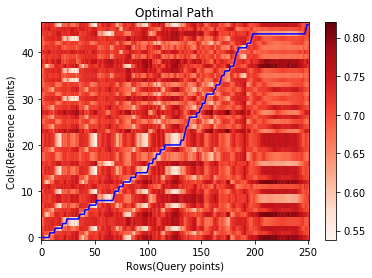

In [23]:
### START CODE BLOCK ###
import matplotlib.cm as cm
fig = plt.figure(1)
ax = fig.add_subplot(111)
plot1 = plt.imshow(C.T, origin='lower', cmap='Reds', interpolation='nearest', aspect = 'auto')
plt.colorbar()
path_x = [point[0] for point in path]
path_y = [point[1] for point in path]
plot2 = plt.plot(path_x, path_y, 'B')
xlim = ax.set_xlim((-0.5, C.shape[0]-0.5))
ylim = ax.set_ylim((-0.5, C.shape[1]-0.5))
plt.xlabel("Rows(Query points)")
plt.ylabel("Cols(Reference points)")
plt.title("Optimal Path")

In [24]:
endCol = path[0][1]
print(path)

[[250  46]
 [249  46]
 [248  45]
 [247  44]
 [246  44]
 [245  44]
 [244  44]
 [243  44]
 [242  44]
 [241  44]
 [240  44]
 [239  44]
 [238  44]
 [237  44]
 [236  44]
 [235  44]
 [234  44]
 [233  44]
 [232  44]
 [231  44]
 [230  44]
 [229  44]
 [228  44]
 [227  44]
 [226  44]
 [225  44]
 [224  44]
 [223  44]
 [222  44]
 [221  44]
 [220  44]
 [219  44]
 [218  44]
 [217  44]
 [216  44]
 [215  44]
 [214  44]
 [213  44]
 [212  44]
 [211  44]
 [210  44]
 [209  44]
 [208  44]
 [207  44]
 [206  44]
 [205  44]
 [204  44]
 [203  44]
 [202  44]
 [201  44]
 [200  44]
 [199  44]
 [198  44]
 [197  43]
 [196  42]
 [195  42]
 [194  42]
 [193  42]
 [192  41]
 [191  41]
 [190  41]
 [189  41]
 [188  41]
 [187  41]
 [186  41]
 [185  41]
 [184  40]
 [183  40]
 [182  39]
 [181  38]
 [180  37]
 [179  37]
 [178  37]
 [177  37]
 [176  36]
 [175  36]
 [174  36]
 [173  36]
 [172  36]
 [171  35]
 [170  35]
 [169  35]
 [168  34]
 [167  33]
 [166  33]
 [165  33]
 [164  33]
 [163  32]
 [162  32]
 [161  31]
 [160  31]

In [25]:
print(endCol, six.shape[1])

46 47


For all of the testcases I ran, the endpoint doesnt quite match up. We have work to do lol